<a href="https://colab.research.google.com/github/rajdeepd/tensorflow_2.0_book_code/blob/master/ch08/GAN_fashionmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demistifying GANs in TensorFlow 2.0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
print(tf.__version__)

2.4.0


## Global Parameters

In [3]:
BATCH_SIZE = 256

In [4]:
BUFFER_SIZE = 60000

In [5]:
EPOCHES = 300

In [6]:
OUTPUT_DIR = "img_fashionmnist" # The output directory where the images of the generator a stored during training

## Loading the MNIST dataset

In [7]:
#mnist = keras.datasets.mnist
fmnist = keras.datasets.fashion_mnist

In [8]:
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [9]:
#train_images[0]
(train_images[0].shape)

(28, 28)

In [10]:
train_images.shape

(60000, 28, 28)

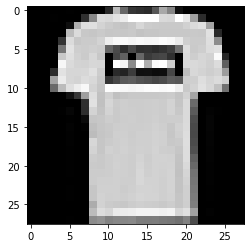

In [11]:
plt.imshow(train_images[1], cmap = "gray")

### Adding the Data to tf.Dataset

In [12]:
train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0],784)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
train_dataset

<BatchDataset shapes: (None, 784), types: tf.float32>

## Generator Network

In [15]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = 100):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 256)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.output_layer = keras.layers.Dense(units=784, activation = "tanh")
        
    def call(self, input_tensor):
        ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return  self.output_layer(x)
    
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))

### Objective Function

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [17]:
def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx) 

### Plotting The Noise (Fake Image)

In [18]:
generator = Generator()

In [19]:
fake_image = generator(np.random.uniform(-1,1, size =(1,100)))

In [20]:
fake_image = tf.reshape(fake_image, shape = (28,28))

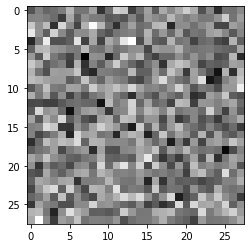

In [21]:
plt.imshow(fake_image, cmap = "gray")

## Discriminator Network

In [22]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        
        #Layers
        self.input_layer = keras.layers.Dense(units = 784)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 128)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        
        self.logits = keras.layers.Dense(units = 1)  # This neuron tells us if the input is fake or real
    def call(self, input_tensor):
          ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.leaky_2(x)
        x = self.leaky_3(x)
        x = self.leaky_3(x)
        x = self.logits(x)
        return x

In [23]:
discriminator = Discriminator()

### Objective Function

In [24]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [25]:
generator_optimizer = keras.optimizers.RMSprop()
discriminator_optimizer = keras.optimizers.RMSprop()

## Training Functions

In [26]:
@tf.function()
def training_step(generator: Discriminator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 32):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, 100)
            g_z = generator(noise)
            d_x_true = discriminator(images) # Trainable?
            d_x_fake = discriminator(g_z) # dx_of_gx

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    

In [27]:
seed = np.random.uniform(-1,1, size = (1, 100)) # generating some noise for the training

In [28]:
# Just to make sure the output directory exists..
import os
directory=OUTPUT_DIR
if not os.path.exists(directory):
    os.makedirs(directory)

In [29]:
def training(dataset, epoches):
    for epoch in range(epoches):
        for batch in dataset: 
            training_step(generator, discriminator, batch ,batch_size = BATCH_SIZE, k = 1)
            
        ## After ith epoch plot image 
        if (epoch % 50) == 0: 
            fake_image = tf.reshape(generator(seed), shape = (28,28))
            print("{}/{} epoches".format(epoch, epoches))
            #plt.imshow(fake_image, cmap = "gray")
            plt.imsave("{}/{}.png".format(OUTPUT_DIR,epoch),fake_image, cmap = "gray")

In [30]:
%%time
training(train_dataset, EPOCHES)

0/300 epoches
50/300 epoches
100/300 epoches
150/300 epoches
200/300 epoches
250/300 epoches
CPU times: user 1h 38min 25s, sys: 3min 3s, total: 1h 41min 28s
Wall time: 53min 33s


## Testing the Generator

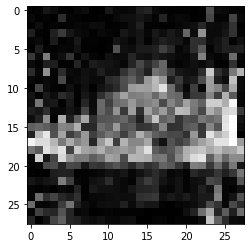

In [31]:
fake_image = generator(np.random.uniform(-1,1, size = (1, 100)))
plt.imshow(tf.reshape(fake_image, shape = (28,28)), cmap="gray")

plt.imsave("article/tshirt.png",tf.reshape(fake_image, shape = (28,28)), cmap="gray")